# A Level-2 Sea Ice Drift (SID) algorithm for CIMR

This notebook implements a prototype for a Level-2 SIED algorithm for the CIMR mission.

We refer to the corresponding [ATBD](https://cimr-algos.github.io/SeaIceDrift_ATBD/intro.html) and especially the [Baseline Algorithm Definition](https://cimr-algos.github.io/SeaIceDrift_ATBD/baseline_algorithm_definition.html#baseline-algorithm-definition).

In particular, the figure below illustrates the overall concept of the processing:
<img src="https://cimr-algos.github.io/SeaIceDrift_ATBD/_images/CIMR_L2_Sea_Ice_Drift_Flow_Diagram.png" width="100%"/>

## Settings

Imports and general settings

In [1]:
%load_ext cython

In [2]:
# Paths

# Getting the path of the notebook (NOTE: not totally safe)

# The paths assume that there is an umbrella CIMR directory (of any name) containing SeaIceDrift_ATBD_v2/ ,
# the CIMR Tools/ directory, and a directory data/L1B/ containing the L1B data, and data/conc/ containing
# a concentration file
import os
cpath = os.path.join(os.getcwd(), '../..')
algpath = os.path.join(cpath, 'SeaIceDrift_ATBD_v2/algorithm/src_sied')
toolpath = os.path.join(cpath, 'Tools')
l1bpath = os.path.join(cpath, 'data/L1B')
griddeffile = os.path.join(cpath, 'Overall_ATBD/etc/grids_py.def')

# Creating a directory structure for processing
concpath = os.path.join(cpath, 'data/conc')
icemaskpath = os.path.join(cpath, 'data/icemask')
swathpath = os.path.join(cpath, 'data/swaths')
procpath = os.path.join(cpath, 'data/processing')
driftpath = os.path.join(cpath, 'data/icedrift')
logpath = os.path.join(cpath, 'data/logs')
figpath = os.path.join(cpath, 'data/figs')
for pth in [concpath, icemaskpath, swathpath, procpath, driftpath, logpath, figpath]:
    if not os.path.isdir(pth):
        os.makedirs(pth)

In [3]:
# Imports

from importlib import reload
import sys
import shutil
import math
import numpy as np
import numpy.ma as ma
import xarray as xr
from netCDF4 import Dataset
from matplotlib import pylab as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import cmocean
import cartopy
import cartopy.crs as ccrs
from pyresample import parse_area_file
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# Local modules contain software code that implement the SIED algorithm
if algpath not in sys.path:
    sys.path.insert(0, algpath)
from icedrift_wrapper import icedrift_wrapper
from process_ice_mask import process_ice_mask
from cp_and_date_change_iceconc import cp_and_date_change_iceconc

# Prototype re-gridding toolbox to handle the L1B input
if toolpath not in sys.path:
    sys.path.insert(0, toolpath)
from tools import io_handler as io
from tools import collocation as coll
from tools import l2_format as l2

In [4]:
# Plot settings

import matplotlib
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)
cmap = cm.viridis
cmapland = matplotlib.colors.ListedColormap(['none', 'grey'])

gridtype = 'ease'
gridin = '{}-ease2-050'
gridout = '{}-ease2-250'
# Some region parameters hard-coded to show only the relevant region
# Overall shape of input grid (4320, 4320)
sl = (1050, 1400, 1050, 1400)
slo = (200, 290, 200, 290)

# EASE plotting region
lon_min = -15
lon_max = 95
lat_min = 74
lat_max = 90

# Settings for gridlines
lon_step = 10
lat_step = 5

## Parametrize the run

User-set parameters for the running of the whole notebook. Note that here a helper script is used to copy a starter ice concentration file from the MET Norway thredds server and change the dates in this. The date changes are required due to the sample input file having a date in the future (2028).

In [5]:
hemi = 'nh'
algos = {'KU': {'channels':('tb19v', 'tb19h'), 'target_band':'KU'},
         'KA': {'channels':('tb37v', 'tb37h'), 'target_band':'KA'}}
wbs = list(algos.keys())
fwdbck = ['fw', 'bk']
polarisation = {'V': 0, 'H': 1}
pols = list(polarisation.keys())

test_card = "radiometric"
if test_card == "geometric":
    # DEVALGO's simulated geometric test card
    l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card == "radiometric":
    # DEVALGO's simulated radiometric test card
    l1bfn = 'W_PT-DME-Lisbon-SAT-CIMR-1B_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'

dt = datetime.strptime('20230420T103323', '%Y%m%dT%H%M%S')

l1bfile = os.path.join(l1bpath, l1bfn)

pdate = datetime.strptime('20280110', '%Y%m%d')
tdate = pdate - relativedelta(years=10)
qdate = pdate + timedelta(days=1)

# Icemask data and output locations
icemaskinputdir = 'https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/{:%Y}/{:%m}'.format(tdate, tdate)
icemaskinputfile = 'ice_conc_{}_ease2-250_cdr-v3p0_{:%Y%m%d}1200.nc'.format(hemi, tdate)
icemaskinput = cp_and_date_change_iceconc(os.path.join(icemaskinputdir, icemaskinputfile), concpath, pdate)

algo_version = '0.1'

plotfigs = True

Written a version of https://thredds.met.no/thredds/dodsC/osisaf/met.no/reprocessed/ice/conc_450a_files/2018/01/ice_conc_nh_ease2-250_cdr-v3p0_201801101200.nc to /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/conc/ice_conc_nh_ease2-250_cdr-v3p0_202801101200.nc


## Step 1: Pre-processing (Icemask, loading the files, Laplacian pre-processing)


### Step 1a: Creating and regridding the ice mask


A land/ocean/ice mask is required to define the areas with ice to the algorithm. This is created from a concentration file, and is stored for future use. Since there can be multiple ice drift calculations per day on different swaths, the mask can be reused once created.

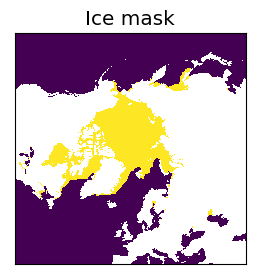

In [6]:
# Creating the ice mask
gridname = gridin.format(hemi)
icemaskname = os.path.join(icemaskpath, 'icemask-multi-{}-{:%Y%m%d}12.nc'.format(gridname, pdate))
if not os.path.isfile(icemaskname):
    process_ice_mask(icemaskinput, icemaskpath, griddeffile, gridname)

# Reading in the ice mask
ie_data = Dataset(icemaskname, 'r')
ie = ie_data['ice_edge'][0, :, :]

# And the same for the output grid
gridnameout = gridout.format(hemi)
icemasknameout = os.path.join(icemaskpath, 'icemask-multi-{}-{:%Y%m%d}12.nc'.format(gridnameout, pdate))
if not os.path.isfile(icemasknameout):
    process_ice_mask(icemaskinput, icemaskpath, griddeffile, gridnameout)
ie_data_out = Dataset(icemasknameout, 'r')
ieout = ie_data_out['ice_edge'][0, :, :]

# Plotting the ice mask
fig = plt.figure(figsize=(3,3))
ax1 = fig.add_subplot(1,1,1)
c1 = ax1.imshow(ie[:], interpolation = 'none', cmap=cmap)
ax1.set_title("Ice mask")
ax1.xaxis.set_tick_params(labelbottom=False)
ax1.yaxis.set_tick_params(labelleft=False)
ax1.set_xticks([])
ax1.set_yticks([])

# Input landmask
landmask = np.zeros_like(ie)
landmask[ie == 9] = 1

# Output landmask
landmaskout = np.zeros_like(ieout)
landmaskout[ieout == 9] = 1

### Step 1b: Loading the data


The L1B data is read in and split into forward and backward scans using software from the `Tools/` repository (a prototype CIMR Regridding Toolbox developed in the CIMR DEVALGO study). These forward and backward scans can be used independently in the algorithm in the same way as different channels and polarisations.

In [7]:
# Read the bands needed of the L1B data
reload(io)

tb_dict = {'tb01':'L', 'tb06':'C', 'tb10':'X', 'tb19':'KU', 'tb37':'KA'}
rev_tb_dict = {v:k for k,v in tb_dict.items()}
bands_needed = []
for alg in algos.keys():
    bands_needed += algos[alg]['channels']
bands_needed = list(set([tb_dict[b[:-1]] for b in bands_needed]))

full_l1b = io.CIMR_L1B(l1bfile, selected_bands=bands_needed, keep_calibration_view=True)

In [8]:
# Split into forward / backward scan

l1b = {}
l1b['fw'], l1b['bk'] = full_l1b.split_forward_backward_scans(method='horn_scan_angle')

### Step 1c: Regridding the data

The horns are interleaved, and then the data is regridded. These are again done with software from `Tools/`. The ice drift will be calculated individually on 8 fields based on the forward and backward scans, waveband (Ku or Ka), and polarity (V or H). A fine EASE2 grid spacing of 5km is chosen for this regridding. 

In [9]:
# Regridding the data

reload(coll)

# Reshaping
l1b_r = {}
for fb in fwdbck:
    l1b_r[fb] = l1b[fb].reshape_interleave_feed()

# Loading the target grid information
gridname = gridin.format(hemi)
new_area_def = parse_area_file(griddeffile, gridname)[0]
new_lons, new_lats = new_area_def.get_lonlats()

# Getting the input lat/lons
lonlats = {}
for ll in ['lon', 'lat']:
    lonlats[ll] = {}
    for fb in fwdbck:
        lonlats[ll][fb] = {}
        for wb in wbs:
            lonlats[ll][fb][wb] = l1b_r[fb].data[wb][ll].data

# Creating data arrays with the V and H layers
what = ('brightness_temperature_v', 'brightness_temperature_h')
params = {'method':'gauss', 'sigmas':25000, 'neighbours':55}
stack_shape = {}
stack = {}
regrid = {}
for fb in fwdbck:
    stack_shape[fb] = {}
    stack[fb] = {}
    regrid[fb] = {}
    for wb in wbs:
        stack_shape[fb][wb] = tuple(list(lonlats['lat'][fb][wb].shape) + [len(what),])
        stack[fb][wb] = np.empty(stack_shape[fb][wb])
        for iw, w in enumerate(what):
            stack[fb][wb][...,iw] = l1b_r[fb].data[wb][w].data
            # Regridding
            # TODO - should params be passed here? With no passing of params, a NN approach with ROI 15000 is used
            regrid[fb][wb] = coll._regrid_fields(new_lons, new_lats, 
                                                 lonlats['lon'][fb][wb], lonlats['lat'][fb][wb], stack[fb][wb])


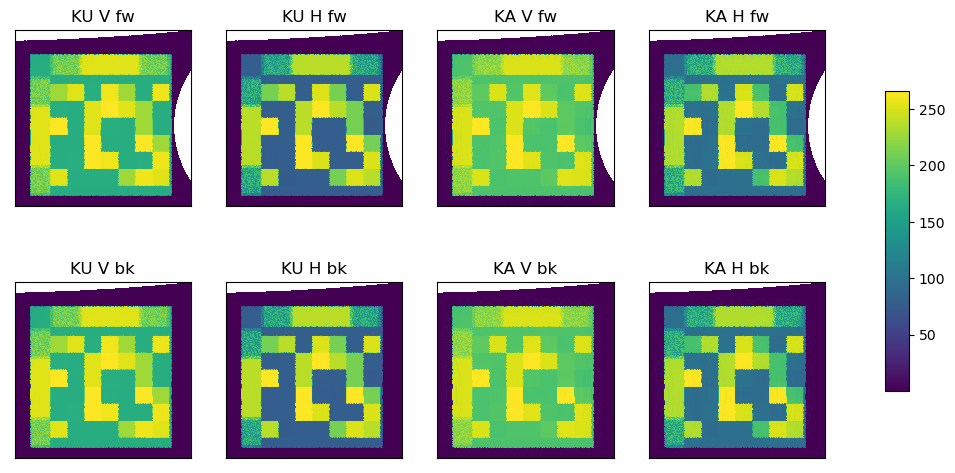

In [10]:
# Plot regridded

fig = plt.figure(figsize=(12,6))
ax = {}
c = {}
shapelayout = (len(fwdbck), len(wbs) * len(pols))
axindex = 1
for fb in fwdbck:
    for wb in wbs:
        for pol in pols:
            ax[axindex] = fig.add_subplot(*shapelayout, axindex)
            c[axindex] = ax[axindex].imshow(regrid[fb][wb][:, :, polarisation[pol]][sl[0]:sl[1], sl[2]:sl[3]], 
                                            interpolation = 'none', origin='lower', cmap=cmap)
            overland = ax[axindex].imshow(landmask[sl[0]:sl[1], sl[2]:sl[3]], interpolation='none',
                                          origin='lower', cmap=cmapland)            
            ax[axindex].invert_yaxis()
            ax[axindex].set_title("{} {} {}".format(wb, pol, fb), fontsize=12)
            ax[axindex].xaxis.set_tick_params(labelbottom=False)
            ax[axindex].yaxis.set_tick_params(labelleft=False)
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
            axindex += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c[1], cax=cbar_ax, shrink=0.5)


# Step 1d: Laplacian pre-processing


Instead of directly using the brightness temperatures in the motion tracking algorithm, the ice features are stabilised and enhanced by applying a Laplacian filter (see ATBD for mathmatical description).

In [11]:
# Laplacian pre-processing

from scipy.ndimage import laplace


# Replace fill value by NaN and remove mask
def _get_nans(img):
    img_masked = np.ma.asarray(img)
    return img_masked.filled(np.nan)

# Replace NaN by fill value and add mask
def _mask_nans(img):
    return np.ma.masked_invalid(img)

nan = {}
lap = {}
fv = {}
for fb in fwdbck:
    nan[fb] = {}
    lap[fb] = {}
    fv[fb] = {}
    for wb in wbs:
        # Convert fill values to NaNs
        nan[fb][wb] = _get_nans(regrid[fb][wb])
        # Laplacian transform
        lap[fb][wb] = laplace(nan[fb][wb])
        # Converting NaNs to fill values
        fv[fb][wb] = _mask_nans(lap[fb][wb])

# Creating a flag field
#define TCIMAGE_OUTSIDE_GRID              -2
#define TCIMAGE_NODATA                    -1
#define TCIMAGE_OK                         0
#define TCIMAGE_UNPROCESSED                1
#define TCIMAGE_FAILED                     2
flag = {}
for fb in fwdbck:
    flag[fb] = {}
    for wb in wbs:
        flag[fb][wb] = np.zeros_like(fv[fb][wb])
        # Masking where the Laplacian didn't work
        flag[fb][wb][fv[fb][wb].mask] = -1
        # Masking where the land and ocean is
        landocean = np.logical_or(ie == 9, ie == 1)
        flag[fb][wb][landocean] = 1


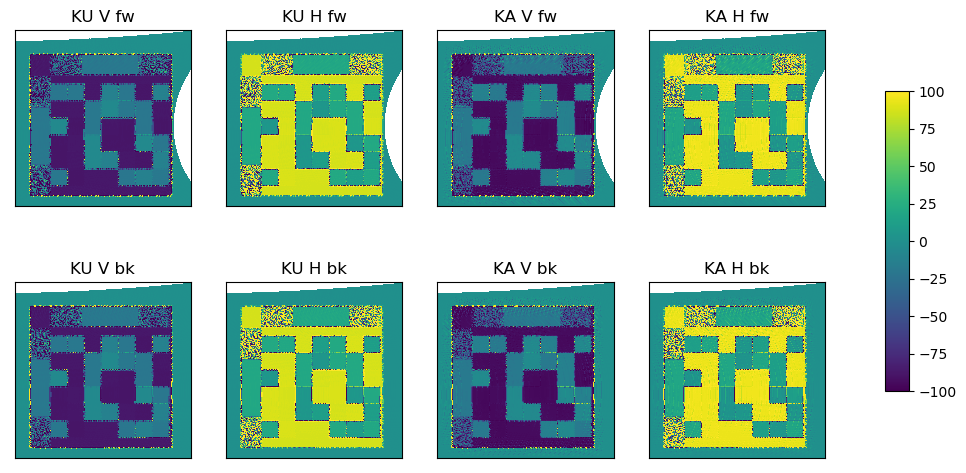

In [12]:
# Plot Laplacian

vmin = -100
vmax = 100

fig = plt.figure(figsize=(12,6))
ax = {}
c = {}
shapelayout = (len(fwdbck), len(wbs) * len(pols))
axindex = 1
for fb in fwdbck:
    for wb in wbs:
        for pol in pols:
            ax[axindex] = fig.add_subplot(*shapelayout, axindex)
            c[axindex] = ax[axindex].imshow(fv[fb][wb][:, :, polarisation[pol]][sl[0]:sl[1], sl[2]:sl[3]], 
                                            interpolation = 'none', origin='lower', cmap=cmap, 
                                            vmin=vmin, vmax=vmax)
            overland = ax[axindex].imshow(landmask[sl[0]:sl[1], sl[2]:sl[3]], interpolation='none',
                                          origin='lower', cmap=cmapland)            
            ax[axindex].invert_yaxis()
            ax[axindex].set_title("{} {} {}".format(wb, pol, fb), fontsize=12)
            ax[axindex].xaxis.set_tick_params(labelbottom=False)
            ax[axindex].yaxis.set_tick_params(labelleft=False)
            ax[axindex].set_xticks([])
            ax[axindex].set_yticks([])
            axindex += 1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(c[1], cax=cbar_ax, shrink=0.5)

# Step 1e: Writing out the file


For ice drift, it is not possible to keep the data only internally. Since two gridded files at different timepoints are required to create each gridded map of icedrift vectors, it is necessary to write each gridded swath file to disk so that it can be read in to be compared with other gridded swath files.

In [13]:
# Note: It is deprecated, but the wrapper and C code still expect a input prog4_string, so accept the deprecation warning for now.
crs_info = {'proj4_string': new_area_def.proj4_string,
             'area_id': new_area_def.area_id,
             'semi_major_axis': 6378137.,
             'semi_minor_axis': 6356752.31424518,
             'inverse_flattening': 298.257223563,
             'reference_ellipsoid_name': "WGS 84",
             'longitude_of_prime_meridian': 0.,
             'prime_meridian_name': "Greenwich",
             'geographic_crs_name': "unknown",
             'horizontal_datum_name': "World Geodetic System 1984",
             'projected_crs_name': "unknown",
             'grid_mapping_name': "lambert_azimuthal_equal_area",
             'latitude_of_projection_origin': 90.,
             'longitude_of_projection_origin': 0.,
             'false_easting': 0.,
             'false_northing': 0.}

/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [14]:
reload(l2)

# Get a template L2 format (netCDF/CF) from the Tools module
ds_l2 = l2.get_CIMR_L2_template('grid', geo_def=new_area_def, add_time=[pdate.timestamp()])

# Create data arrays for the brightness temperatures, laplacian processed and status flags from the template
shp = (1, *regrid[fwdbck[0]][wbs[0]][:, :, polarisation[pol]].shape)
ds_tb = {}
ds_lap = {}
ds_flag = {}
for fb in fwdbck:
    ds_tb[fb] = {}
    ds_lap[fb] = {}
    ds_flag[fb] = {}
    for wb in wbs:
        ds_tb[fb][wb] = {}
        ds_lap[fb][wb] = {}
        ds_flag[fb][wb] = {}
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            ds_tb[fb][wb][pol] = xr.DataArray(regrid[fb][wb][:, :, polarisation[pol]].reshape(shp),
                                              coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                                              attrs=ds_l2['template'].attrs, name='{}{}'.format(chan, fb))
            ds_tb[fb][wb][pol].attrs['standard_name'] = 'brightness_temperature'
            ds_tb[fb][wb][pol].attrs['long_name'] = 'Brightness temperature {}'.format(chan, fb)
            ds_tb[fb][wb][pol].attrs['coverage_content_type'] = 'physicalMeasurement'
            ds_tb[fb][wb][pol].attrs['units'] = 'K'
            ds_l2 = ds_l2.merge(ds_tb[fb][wb][pol])
            
            ds_lap[fb][wb][pol] = xr.DataArray(fv[fb][wb][:, :, polarisation[pol]].reshape(shp),
                                               coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                                               attrs=ds_l2['template'].attrs, name='{}{}_lap'.format(chan, fb))
            ds_lap[fb][wb][pol].attrs['long_name'] = 'Laplacian of brightness temperature {}'.format(chan, fb)
            ds_lap[fb][wb][pol].attrs['coverage_content_type'] = 'auxiliaryInformation'
            ds_lap[fb][wb][pol].attrs['units'] = 1
            ds_l2 = ds_l2.merge(ds_lap[fb][wb][pol])
            
            ds_flag[fb][wb][pol] = xr.DataArray(flag[fb][wb][:, :, polarisation[pol]].reshape(shp),
                                                coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                                                attrs=ds_l2['template'].attrs, 
                                                name='{}{}_lap_flag'.format(chan, fb))
            ds_flag[fb][wb][pol].attrs['standard_name'] = 'status_flag'
            ds_flag[fb][wb][pol].attrs['long_name'] = 'Status flag for Laplacian of brightness temperature {}'.format(chan, fb)
            ds_flag[fb][wb][pol].attrs['coverage_content_type'] = 'qualityInformation'
            ds_flag[fb][wb][pol].attrs['units'] = 1
            ds_l2 = ds_l2.merge(ds_flag[fb][wb][pol])

# Create a data array for dtime from the template
dtime = np.full_like(regrid[fwdbck[0]][wbs[0]][:, :, 0], pdate.timestamp()).reshape(shp)
ds_dtime = xr.DataArray(dtime, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                        attrs=ds_l2['template'].attrs, name='dtime')
ds_dtime.attrs['long_name'] = 'Time'
ds_dtime.attrs['standard_name'] = 'time'
ds_dtime.attrs['coverage_content_type'] = 'auxiliaryInformation'
ds_dtime.attrs['units'] = 'seconds since 1970-01-01 00:00:00'
ds_l2 = ds_l2.merge(ds_dtime)

# Create a data array for ice edge from the template
ds_ie = xr.DataArray(ie.reshape(shp), coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                     attrs=ds_l2['template'].attrs, name='ice_edge')
ds_ie.attrs['long_name'] = 'Ice edge'
ds_ie.attrs['coverage_content_type'] = 'auxiliaryInformation'
ds_ie.attrs['units'] = 1
ds_l2 = ds_l2.merge(ds_ie)

# Create a data array for time, needed by the C code
timedata = np.full_like(regrid[fb][wb][0, 0, 0], pdate.timestamp())
ds_l2['vtime'] = (('time'), timedata.reshape(1,))
ds_l2['time'].attrs = {'units': "seconds since 1970-01-01 00:00:00"}
ds_l2.attrs['long_name'] = 'Time'
ds_l2.attrs['coverage_content_type'] = 'auxiliaryInformation'
ds_l2.attrs['units'] = "seconds since 1970-01-01 00:00:00"

# Customize the global attributes
ds_l2.attrs['title'] = 'CIMR intermediate brightness temperatures for ice drift calculation'
ds_l2.attrs['summary'] = 'Intermediate brightness temperatures and Laplacian-processed fields with their status flags, written as intermadiate-processing file for ice drift calculations'
ds_l2.attrs['l1b_file'] = l1bfn
ds_l2.attrs['algorithm_version'] = algo_version
ds_l2.attrs['creator_name'] = 'Emily Down'
ds_l2.attrs['creator_email'] = 'emilyjd@met.no'
ds_l2.attrs['institution'] = 'Norwegian Meteorological Institute'

# CRS information needed for C code
ds_l2['crs'].attrs = crs_info

# Need to rename x and y to xc and yc for X code
ds_l2= ds_l2.rename({'x': 'xc','y': 'yc'})
    
# Remove the 'template' variable (we don't need it anymore)
#ds_l2 = ds_l2.drop('template')

# Write to file
dsname = os.path.join(procpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, pdate))
ds_l2.to_netcdf(dsname, 'w', format="NETCDF4_CLASSIC")
print("Written {}".format(dsname))

# Setting this up for potential reruns
ds_l2_copy = ds_l2.copy()


Written /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/bt_nh-ease2-050_20280110.nc


### Step 1f (temporary): Creating a test gridded file with "time difference" 24h and pixel shifts added in each x and y


This is a temporary part of this notebook, to create a "test" file with different gridded brightness temperatures and a different timepoint. This is required for calculation of ice drift vectors. In this example, a constant shift of +3 pixels in the x-direction and +4 pixels in the y-direction is chosen. In operation, two swaths at different timepoints will be processed in the algorithm to retrieve the icedrift.

In [15]:
# Create a shifted file. These are the pixel shifts
pixshx = 3
pixshy = 4

# Take a copy of the data xarray
ds_shift = ds_l2_copy.copy()

# Add the Laplacian mask variable
ds_msk = {}
ds_msk = {}
ds_msk = {}
for fb in fwdbck:
    ds_msk[fb] = {}
    for wb in wbs:
        ds_msk[fb][wb] = {}
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            ds_msk[fb][wb][pol] = xr.DataArray(fv[fb][wb][:, :, polarisation[pol]].mask.reshape(shp),
                                               coords=ds_shift['template'].coords, dims=ds_shift['template'].dims,
                                               attrs=ds_shift['template'].attrs, name='{}{}_msk'.format(chan, fb))
            ds_msk[fb][wb][pol].attrs['long_name'] = 'Mask for Laplacian of brightness temperature {}'.format(chan, fb)
            ds_msk[fb][wb][pol].attrs['coverage_content_type'] = 'auxiliaryInformation'
            ds_msk[fb][wb][pol].attrs['units'] = 1
            ds_shift = ds_shift.merge(ds_msk[fb][wb][pol])

# Shifting the data pixels of the arrays
ds_shift_tb = {}
ds_shift_lap = {}
ds_shift_flag = {}
for fb in fwdbck:
    ds_shift_tb[fb] = {}
    ds_shift_lap[fb] = {}
    ds_shift_flag[fb] = {}
    for wb in wbs:
        ds_shift_tb[fb][wb] = {}
        ds_shift_lap[fb][wb] = {}
        ds_shift_flag[fb][wb] = {}
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            # Shift can be used in xarray to shift dimension by number of pix. Note that the dimensions must be
            # called x and y within xarray
            chan = algos[wb]['channels'][polarisation[pol]]
            tbname = '{}{}'.format(chan, fb)
            ds_shift_tb[fb][wb] = ds_shift.get(tbname).shift(xc=pixshx, yc=pixshy)
            ds_shift[tbname].data = ds_shift_tb[fb][wb]
            # Shifting the Laplacian field
            lapname = '{}{}_lap'.format(chan, fb)
            ds_shift_lap[fb][wb] = ds_shift.get(lapname).shift(xc=pixshx, yc=pixshy)
            ds_shift[lapname].data = ds_shift_lap[fb][wb]
            # Flag field (want the data shifted, the landmask not)  
            flagname = '{}{}_lap_flag'.format(chan, fb)
            ds_shift_flag[fb][wb] = np.zeros_like(ds_shift_lap[fb][wb])
            # Masking where the Laplacian failed
            maskname = '{}{}_msk'.format(chan, fb)
            fmsk_shft = ds_shift.get(maskname).shift(xc=pixshx, yc=pixshy)
            ds_shift_flag[fb][wb][fmsk_shft == 1] = -1
            # Masking where the land and ocean is
            landocean = np.logical_or(ie == 9, ie == 1).reshape(shp)
            (ds_shift_flag[fb][wb])[landocean] = 1
            ds_shift[flagname].data = ds_shift_flag[fb][wb]

# Shift time by 24h
ds_shift['dtime'].data = np.full_like(regrid[fwdbck[0]][wbs[0]][:, :, 0], qdate.timestamp()).reshape(shp)
ds_shift.assign_coords(time = [qdate.timestamp()])

# Remove the mask variables (we don't need them anymore)
for fb in fwdbck:
    for wb in wbs:
        for pol in pols:
            chan = algos[wb]['channels'][polarisation[pol]]
            maskname = '{}{}_msk'.format(chan, fb)
            ds_shift = ds_shift.drop_vars(maskname)

# Write to file
dsname2 = os.path.join(procpath, 'bt_{}_{:%Y%m%d}.nc'.format(gridname, qdate))
ds_shift.to_netcdf(dsname2, 'w', format="NETCDF4_CLASSIC")
print("Written {}".format(dsname2))

Written /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/bt_nh-ease2-050_20280111.nc


## Step 2: Cross-correlation algorithm


For the Continuous Maximum Cross-Correlation algorithm, two brightness temperature gridded files, enhanced by the Laplacian algorithm and with different timestamps, are required. The algorithm matches features between these images on a fractional pixel grid.

The steps of the cross-correlation algorithm are:
1. Determination of which pixels should be included in the cross-correlation, excluding land and ocean pixels.
2. Fractional pixel cross-correlation simultaneously on the gridded swaths - forward/back scans, V and H polarisations, Ku and Ka channels.
3. Correction of erroneous vectors using the nearest neighbour method and creation of status flags.

### Step 2a: Run the cross-correlation algorithm to find the ice drift

Currently the C code has limited memory for channels, so the forward and backward scans with V and H polarisations are accepted by the code. It should be possible to add Ka-band later. 

In addition, the forward and backward scans are treated here as having the same timestamp, later it can be refined to include the 7-minute delay between these two.

In [16]:
# Copying the files with new names, to interface with the C-code

chanstr = 'tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk'
newname1 = 'tc_wght_cimr-cimr_{}_{}_{}12.nc'.format(chanstr, gridin.format(hemi), datetime.strftime(pdate, '%Y%m%d'))
newname2 = 'tc_wght_cimr-cimr_{}_{}_{}12.nc'.format(chanstr, gridin.format(hemi), datetime.strftime(qdate, '%Y%m%d'))
shutil.copyfile(dsname, os.path.join(os.path.dirname(dsname), newname1))
shutil.copyfile(dsname2, os.path.join(os.path.dirname(dsname), newname2))

'/home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc'

In [17]:
%load_ext autoreload
%autoreload

from icedrift_wrapper import icedrift_wrapper
rad = 100.
rad_neigh = 150.
# Original rad=75. rad_neigh=125.
# Worked with rad=100. rad_neigh=150.
# rad = 25. rad_neigh=150. has lots of corrected by neighbours, but a better field
chan_list = ['tb37hfw_lap', 'tb37vfw_lap', 'tb37hbk_lap', 'tb37vbk_lap']
idrift = icedrift_wrapper(pdate, qdate, procpath, procpath, driftpath, os.path.join(logpath, 'cmcc-test.log'),
                          'cimr-cimr', gridin.format(hemi), chan_list, rad, rad_neigh, 
                          area_out=gridout.format(hemi))



Daily maps found (cimr-cimr):

	Day 1 : /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011012.nc 

	Day 2 : /home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/processing/tc_wght_cimr-cimr_tb19hfw-tb19vfw-tb19hbk-tb19vbk-tb37hfw-tb37vfw-tb37hbk-tb37vbk_nh-ease2-050_2028011112.nc 





/modules/rhel8/conda/install/envs/production-08-2023/lib/python3.9/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


Calling the C core code...
 
 LOGMSG [icedrift_solve_core 2024-06-24 10:44]:
	Start processing.
 
	Log file is </home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/logs/cmcc-test.log>
	Radius for pattern #0 is 100.0km
	Radius for pattern #1 is 50.0km
	Maximum drift distance is 38.88km
 ._____. ._____. ._____. ._____. ._____. ._____. {-6/+0} ._____. ._____. ._____. ._____. ._____. ._____. 



 ._____. ._____. ._____. {-5/-3} {-5/-2} {-5/-1} {-5/+0} {-5/+1} {-5/+2} {-5/+3} ._____. ._____. ._____. 



 ._____. ._____. {-4/-4} {-4/-3} {-4/-2} {-4/-1} {-4/+0} {-4/+1} {-4/+2} {-4/+3} {-4/+4} ._____. ._____. 



 ._____. {-3/-5} {-3/-4} {-3/-3} {-3/-2} {-3/-1} {-3/+0} {-3/+1} {-3/+2} {-3/+3} {-3/+4} {-3/+5} ._____. 



 ._____. {-2/-5} {-2/-4} {-2/-3} {-2/-2} {-2/-1} {-2/+0} {-2/+1} {-2/+2} {-2/+3} {-2/+4} {-2/+5} ._____. 



 ._____. {-1/-5} {-1/-4} {-1/-3} {-1/-2} {-1/-1} {-1/+0} {-1/+1} {-1/+2} {-1/+3} {-1/+4} {-1/+5} ._____. 



 {+0/-6} {+0/-5} {+0/-4} {+0/-3} {+0/-2} {+0

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,8.663092}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,8.663092}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,8.663092}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,8.663092}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,8.663092}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,8.663092}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.996160}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.996160}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now i

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,-1.120169}. Score=-nan
ERROR (compute_Posterior_Uncertainties) [p:98270] Negative variances (-148175.912802,-131296.983063)
ERROR (compute_Posterior_Uncertainties) [p:98294] Negative variances (0.002544,-0.00016

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.005277}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.995824}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.995824}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.993110}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.993110}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.993110}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.993110}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.993110}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.993110}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002082}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.996981}. Score=-nan
ERROR (compute_Posterior_Uncertainties) [p:106959] Negative variances (-0.000830,0.007723)
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999919}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999919}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999919}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999919}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999919}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999919}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.9

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.004728}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.004728}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.004728}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.004728}. Score=-nan
ERROR (compute_Posterior_Uncertainties) [p:109083] Negative variances (0.561858,-0.918691)
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.996777}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.996777}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.996777}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.9

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,14.999248}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.003296}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,15.002281}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to

The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is X: {0.000000,0.000000}. Score=-nan
The maximum number of iterations (1000) is reached. The best point up to now is 

### Step 2b: Format L2 file and write to disk

The output icedrift file is processed and written, with metadata.

In [18]:
driftx = ma.asarray(idrift['drift_x'])
driftx.mask = driftx < -1e9
drifty = ma.asarray(idrift['drift_y'])
drifty.mask = drifty < -1e9
flag = ma.asarray(idrift['flag'])

dms = driftx.shape
ddx = driftx.reshape(1, dms[0], dms[1])
ddy = drifty.reshape(1, dms[0], dms[1])
stdx = ma.asarray(idrift['std_x'])
stdx.mask = stdx < -1e9
stdx = stdx.reshape(1, dms[0], dms[1])
stdy = ma.asarray(idrift['std_y'])
stdy.mask = stdy < -1e9
stdy = stdy.reshape(1, dms[0], dms[1])
dflag = ma.asarray(idrift['flag'])
dflag = flag.reshape(1, dms[0], dms[1])


In [19]:
reload(l2)

# Output grid
og = gridout.format(hemi)
out_area_def = parse_area_file(griddeffile, og)[0]
olons, olats = out_area_def.get_lonlats()

# Get a template L2 format (netCDF/CF) from the Tools module
ds_l2 = l2.get_CIMR_L2_template('grid', geo_def=out_area_def, add_time=[pdate.timestamp()])

# Create a DataArray for x and y icedrift from the template
da_dx = xr.DataArray(ddx, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='driftX')
da_dx.attrs['long_name'] = 'x-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_dx.attrs['standard_name'] = 'x_component_sea_ice_drift'
da_dx.attrs['units'] = 'km'
da_dx.attrs['coverage_content_type'] = 'physicalMeasurement'
da_dx.attrs['auxiliary_variables'] = 'status_flag'
da_dy = xr.DataArray(ddy, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='driftY')
da_dy.attrs['long_name'] = 'y-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_dy.attrs['standard_name'] = 'y_component_sea_ice_drift'
da_dy.attrs['units'] = 'km'
da_dy.attrs['coverage_content_type'] = 'physicalMeasurement'
da_dy.attrs['auxiliary_variables'] = 'status_flag'

# Create a DataArray for std x and y icedrift from the template
da_stddx = xr.DataArray(stdx, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='stdX')
da_stddx.attrs['long_name'] = 'Standard deviation of x-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_stddx.attrs['units'] = 'km'
da_stddx.attrs['coverage_content_type'] = 'auxiliaryInformation'
da_stddx.attrs['auxiliary_variables'] = 'status_flag'
da_stddy = xr.DataArray(stdy, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='stdY')
da_stddy.attrs['long_name'] = 'Standard deviation of y-component of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_stddy.attrs['units'] = 'km'
da_stddy.attrs['coverage_content_type'] = 'auxiliaryInformation'
da_stddy.attrs['auxiliary_variables'] = 'status_flag'

# Create a DataArray for the status flag from the template
da_flag = xr.DataArray(dflag, coords=ds_l2['template'].coords, dims=ds_l2['template'].dims,
                       attrs=ds_l2['template'].attrs, name='status_flag')
da_flag.attrs['long_name'] = 'Status flag of Sea Ice Drift from the CIMR ice drift algorithm v{}'.format(algo_version)
da_flag.attrs['units'] = 1
da_flag.attrs['coverage_content_type'] = 'auxiliaryInformation'

# Add the data arrays to the ds_l2 object
ds_l2 = ds_l2.merge(da_dx)
ds_l2 = ds_l2.merge(da_dy)
ds_l2 = ds_l2.merge(da_stddx)
ds_l2 = ds_l2.merge(da_stddy)
ds_l2 = ds_l2.merge(da_flag)

# Customize the global attributes
ds_l2.attrs['title'] = 'CIMR L2 Sea Ice Drift'
ds_l2.attrs['summary'] = 'Sea Ice Drift computed with the prototype algorithm developed in the ESA CIMR DEVALGO study. The algorithm combines Ku and Ka imagery channels. The product file contains the sea ice drift, its uncertainties, and processing flags.'
ds_l2.attrs['l1b_file'] = os.path.basename(l1bfile)
ds_l2.attrs['algorithm_version'] = algo_version

ds_l2.attrs['creator_name'] = 'Emily Down and Thomas Lavergne'
ds_l2.attrs['creator_email'] = 'emilyjd@met.no'
ds_l2.attrs['institution'] = 'Norwegian Meteorological Institute'

# Remove the 'template' variable (we don't need it anymore)
ds_l2 = ds_l2.drop_vars('template')

# Write to file
l2_n = 'cimr_devalgo_l2_sid_{}_{}.nc'.format(og, test_card)
l2_n = os.path.join(driftpath, l2_n)
ds_l2.to_netcdf(l2_n, format='NETCDF4_CLASSIC')
print(l2_n)

/home/emilyjd/cimr-devalgo/SeaIceDrift_ATBD_v2/algorithm/../../data/icedrift/cimr_devalgo_l2_sid_nh-ease2-250_radiometric.nc


### Step 2c: Plotting

Here an example plot of the icedrift output is made.

In [20]:
def crs_create(gridtype, hemi):

    # Define grid based on region
    if gridtype == 'polstere':
        if hemi == 'nh':
            plot_proj4_params = {'proj': 'stere',
                                 'lat_0': 90.,
                                 'lat_ts' : 70.,
                                 'lon_0': -45.0,
                                 'a': 6378273,
                                 'b': 6356889.44891}
            plot_globe = ccrs.Globe(semimajor_axis=plot_proj4_params['a'],
                                    semiminor_axis=plot_proj4_params['b'])
            plot_crs = ccrs.NorthPolarStereo(
                central_longitude=plot_proj4_params['lon_0'], globe=plot_globe)
        else:
            plot_proj4_params = {'proj': 'stere',
                                 'lat_0': -90.,
                                 'lat_ts' : -70.,
                                 'lon_0': 0.,
                                 'a': 6378273,
                                 'b': 6356889.44891}
            plot_globe = ccrs.Globe(semimajor_axis=plot_proj4_params['a'],
                                    semiminor_axis=plot_proj4_params['b'])
            plot_crs = ccrs.SouthPolarStereo(
                central_longitude=plot_proj4_params['lon_0'], globe=plot_globe)
    elif gridtype == 'ease':
        if hemi == 'nh':
            plot_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                                      central_latitude=90,
                                                      false_easting=0,
                                                      false_northing=0)
        else:
            plot_crs = ccrs.LambertAzimuthalEqualArea(central_longitude=0,
                                                      central_latitude=-90,
                                                      false_easting=0,
                                                      false_northing=0)
    else:
        raise ValueError("Unrecognised region {}".format(region))

    return(plot_crs)

In [21]:
def flag_arrow_col(flag, procfmt=False):

    if procfmt:
        flgfmt = 'proc'
    else:
        flgfmt = 'final'

    # Use colours from https://sashamaps.net/docs/resources/20-colors/
    fblack = '#000000'
    fmaroon = '#800000'
    forange = '#f58231'
    fnavy = '#000075'
    fblue = '#4363d8'
    flavender = '#dcbeff'
    fgrey = '#a9a9a9'

    fbrown = '#9A6324'
    fteal = '#469990'
    fgreen = '#3cb44b'
    fcyan = '#42d4f4'
    fmagenta = '#f032e6'

    fred = '#e6194B'
    fpurple = '#911eb4'

    flag_cols = {}
    flag_cols['final'] = {30: fblack,   # Nominal quality
                          20: fbrown,   # Single-sensor, with smaller pattern
                                        # block
                          21: forange,  # Single-sensor, with neighbours as
                                        # constraint
                          22: fmaroon,  # Interpolated
                          23: fcyan,    # Gap filling in wind drift
                          24: fteal,    # Vector replaced by wind drift
                          25: fnavy,    # Blended satellite and wind drift
}
    flag_cols['proc'] = {0: fblack,     # Nominal quality
                         16: fpurple,   # Interpolated
                         13: fred,      # Single-sensor, with neighbours as
                                        # constraint
                         17: fgreen,    # Single-sensor, with smaller
                                        # pattern block
}

    default = 'black'
    if flag in flag_cols[flgfmt].keys():
        return flag_cols[flgfmt][flag]
    else:
        return default

In [22]:
scale = 1000.
pc = ccrs.PlateCarree()

def plotdriftarr(ax, plot_crs, data_crs, lon, lat, dx, dy, sflag, driftflags=True):
    
    for i in range(dx.size):
        try:
            x0, y0 = plot_crs.transform_point(lon[~dx.mask][i], lat[~dx.mask][i], src_crs=pc)
            adx = dx[~dx.mask][i]
            ady = dy[~dy.mask][i]
            len_arrow = math.sqrt(adx**2 + ady**2)

            # Calculate the endpoints and therefore dx, dy components of the drift arrows in the plot
            # coordinate system
            xorig, yorig = data_crs.transform_point(lon[~dx.mask][i], lat[~dx.mask][i], src_crs=pc)
            xarr = xorig + adx
            yarr = yorig + ady
            x1, y1 = plot_crs.transform_point(xarr, yarr, src_crs=data_crs)
            pdx = (x1 - x0) * scale
            pdy = (y1 - y0) * scale
            
            # Set the colour of the drift arrows if this should be
            # done with status flags
            if driftflags:
                myflag = sflag[~dx.mask][i]
                ar_col = flag_arrow_col(myflag, procfmt=True)
            else:
                ar_col = 'black'

            # If the arrow is too small, mark a symbol instead
            if len_arrow * scale < 2000:
                plt.plot(x0, y0, 's', color=ar_col, markersize=1)
            else:
                head_length = 0.3 * len_arrow * scale
                plt.arrow(x0, y0, pdx, pdy, color=ar_col,
                    shape='full', head_length=head_length,
                    head_width=15000,
                    fill=True, length_includes_head=True,
                    width=4000)

        except:
            pass # Outside the range of points

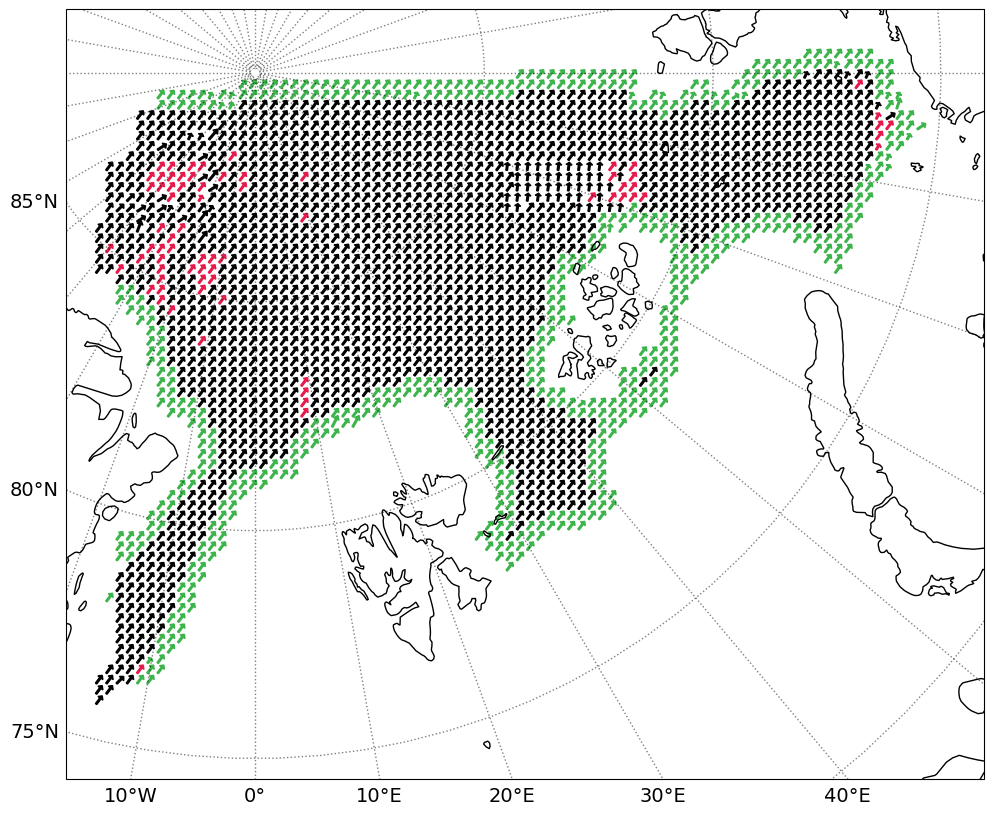

FLAG VALUES 
Unprocessed pixel                              -1
Nominal                                        0
Outside image border                           1
Close to image border                          2
Pixel center over land                         3
No ice                                         4
Close to coast or edge                         5
Close to missing pixel                         6
Close to unprocessed pixel                     7
Icedrift optimisation failed                   8
Icedrift failed                                9
Icedrift with low correlation                  10
Icedrift calculation took too long             11
Icedrift calculation refused by neighbours     12
Icedrift calculation corrected by neighbours   13
Icedrift no average                            14
Icedrift masked due to summer season           15
Icedrift multi-oi interpolation                16
Icedrift calcuated with smaller pattern        17
Icedrift masked due to NWP                     

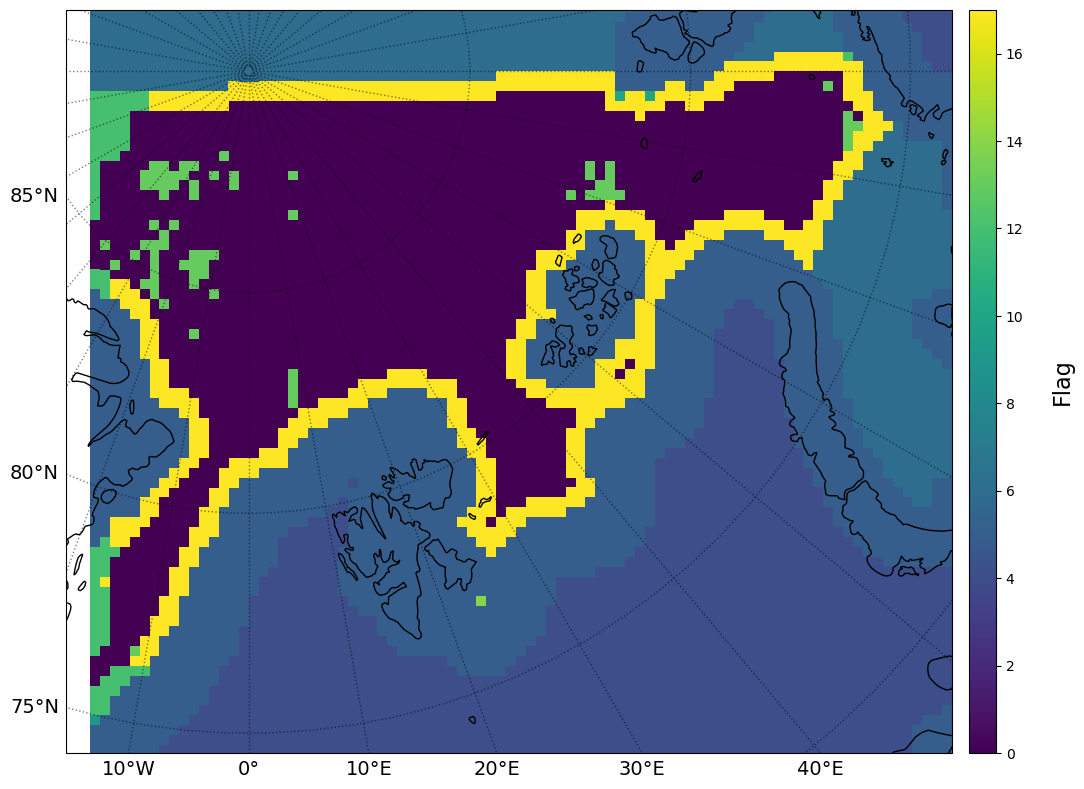

In [23]:
# Plotting the ice drift with arrows
# Modified from the SeaSurfaceTemperature_ATBD_v2, by Emy Alerskans

# Drift data
xydata = {'dx': driftx, 'dy': drifty}
limminxy = np.nanmin([np.nanmin(a) for a in xydata.values()])
limminxy = limminxy - 0.1 * abs(limminxy)
limmaxxy = np.nanmax([np.nanmax(a) for a in xydata.values()])
limmaxxy = limmaxxy + 0.1 * abs(limmaxxy)
limminflag = np.nanmin(flag)
limmaxflag = np.nanmax(flag)

# Output lat/lons
og = gridout.format(hemi)
out_area_def = parse_area_file(griddeffile, og)[0]
olons, olats = out_area_def.get_lonlats()

# Coordinate reference systems
plot_crs = crs_create(gridtype, hemi)
pc = ccrs.PlateCarree()
if 'ease' in gridout:
    data_crs = crs_create('ease', hemi)
else:
    data_crs = crs_create('polstere', hemi)

# Plotting drift
fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(1, 1, 1, projection=plot_crs)

plotdriftarr(ax, plot_crs, data_crs, olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
             driftx[slo[0]:slo[1], slo[2]:slo[3]], drifty[slo[0]:slo[1], slo[2]:slo[3]],
             flag[slo[0]:slo[1], slo[2]:slo[3]], driftflags=True)

ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}    

if plotfigs:
    plt.savefig(os.path.join(figpath, 'drift_rad{}.png'.format(int(rad))))
plt.show()

# Status flags
fig = plt.figure(figsize=[12, 10])
ax = fig.add_subplot(1, 1, 1, projection=plot_crs)
im = ax.pcolormesh(olons[slo[0]:slo[1], slo[2]:slo[3]], olats[slo[0]:slo[1], slo[2]:slo[3]], 
                    flag[:][slo[0]:slo[1], slo[2]:slo[3]], transform=pc,
                    cmap=cmap, vmin=limminflag, vmax=limmaxflag)
ax.coastlines()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='k', alpha=0.5, linestyle=':')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, lon_step))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, lat_step))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}
        
# Colourbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad="2%", axes_class=plt.Axes)
cb = fig.colorbar(im, cax=cax)
cb.set_label(label="Flag", fontsize=16, labelpad=20.0)
cb.ax.set_ylim(limminflag, limmaxflag)
        
print("\
FLAG VALUES \n\
Unprocessed pixel                              -1\n\
Nominal                                        0\n\
Outside image border                           1\n\
Close to image border                          2\n\
Pixel center over land                         3\n\
No ice                                         4\n\
Close to coast or edge                         5\n\
Close to missing pixel                         6\n\
Close to unprocessed pixel                     7\n\
Icedrift optimisation failed                   8\n\
Icedrift failed                                9\n\
Icedrift with low correlation                  10\n\
Icedrift calculation took too long             11\n\
Icedrift calculation refused by neighbours     12\n\
Icedrift calculation corrected by neighbours   13\n\
Icedrift no average                            14\n\
Icedrift masked due to summer season           15\n\
Icedrift multi-oi interpolation                16\n\
Icedrift calcuated with smaller pattern        17\n\
Icedrift masked due to NWP                     18\n\
")